In [1]:

import torch

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt


from torch.utils.data import Dataset, DataLoader  # Import Dataset and DataLoader
import torchvision.transforms as transforms
import torch
import torch.optim as optim
import torch.nn.functional as F


from utility import CityscapeSegTemp, get_min_max, train, evaluate, plot_samples, plot_predictions, plot_metrics

from utility import cityscapes_cmap, plot_class_colors


import multiprocessing as mp

mp.set_start_method('spawn', force=True)

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_name = torch.cuda.get_device_name(0)  
elif torch.backends.mps.is_available():  # Check for M1 GPU availability
    device = torch.device("mps")  # M1 GPU
    gpu_name = "Apple M1"
else:
    device = torch.device("cpu")
    gpu_name = "CPU"

print(f"Using device: {device}, GPU: {gpu_name}")

Using device: cuda, GPU: NVIDIA GeForce RTX 4090


In [3]:
# temp_min, temp_max = get_min_max('./data')

temp_min, temp_max = 13.5, 44.5 # get_min_max will give this value, manually defined just to make it faster

print(temp_min, temp_max)

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

13.5 44.5


In [4]:
aug = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = CityscapeSegTemp(root_dir ='./data', split = 'train', 
                                 transform = aug, 
                                #  temp_scale=(temp_min, temp_max)
                                 )



val_dataset =   CityscapeSegTemp(root_dir = './data', split= 'val', 
                                 transform = aug,
                                #  temp_scale=(temp_min, temp_max)
                                 )


batch_size = 32

# reload Train and Validation with num_worker ( apparently there is a glitch with windows and using if __name__ == '__main__' num_workers works)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 14)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers = 14)


In [5]:
unique_mask_values = set()

for i in range(20):
    _, (mask, _) = val_dataset[i]  # Assuming this is how your dataset returns values
    unique_values = torch.unique(mask).tolist()  # Convert to a list of values
    unique_mask_values.update(unique_values)  # Update the set with new unique values

print(f'Unique mask values in the dataset: {unique_mask_values}')
print(f'Total: {len(unique_mask_values)}')

Unique mask values in the dataset: {0, 1, 2, 3, 4, 5, 6}
Total: 7


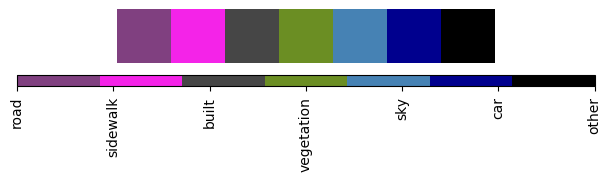

In [6]:
classes = [
            'road', 
           'sidewalk', 
           'built',
          #  'construction', 
         #   'object', 
           'vegetation', 
        #    'terrain', 
           'sky',
         #   'human', 
           'car', 
         #   'truck/bus', 
          #  'motorcycle/bicycle' ,  
           'other']

plot_class_colors(classes, cityscapes_cmap)

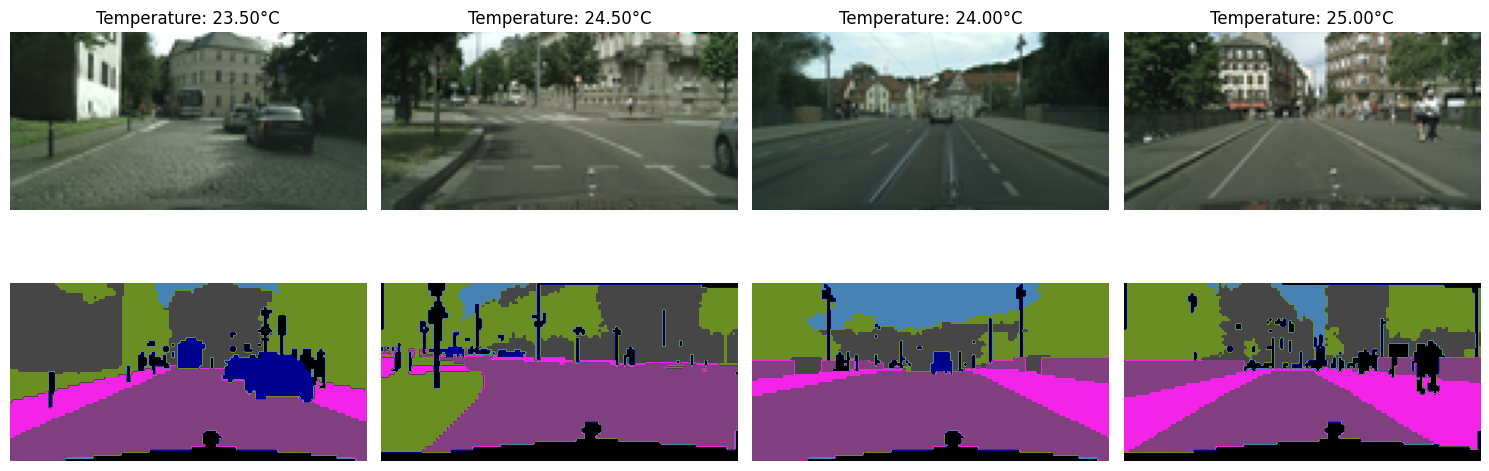

In [7]:
plot_samples(train_loader, unnormalize= True, mean = mean , std = std, 
            #  temp_scale=(temp_min, temp_max)
             )

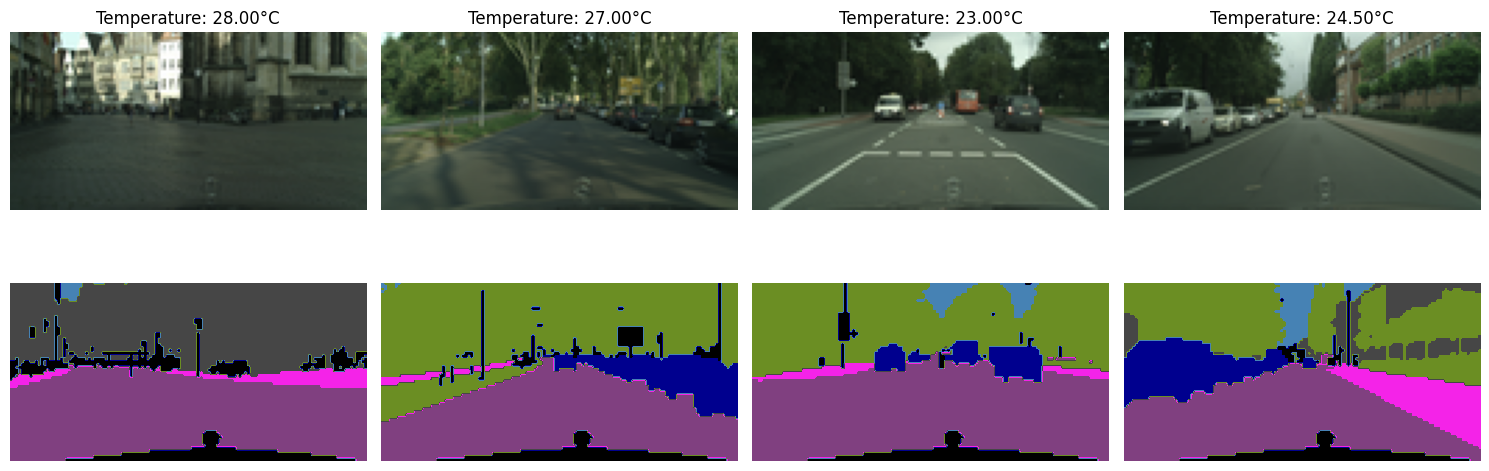

In [8]:
plot_samples(val_loader, unnormalize= True, mean = mean , std = std, 
            #  temp_scale=(temp_min, temp_max)
             )

In [9]:
from blocks import Bottleneck, ASPP, UpsampleBlock, ResidualBlock

class ResidualUNet(nn.Module):
    def __init__(self, num_classes):
        super(ResidualUNet, self).__init__()
        
        self.encoder1 = self._make_layer(3, 64, 1)    
        self.encoder2 = self._make_layer(64, 128, 3, stride =2) # 1/2
        self.encoder3 = self._make_layer(128, 256, 4, stride=2) # 1/4
        self.encoder4 = self._make_layer(256, 512, 6, stride=2) # 1/8
        self.encoder5 = self._make_layer(512, 1024, 3)          # 1/16 

        self.aspp_mask = ASPP(1024, 1024, [6, 12, 18])
       
        self.upsample1 = UpsampleBlock(1024, 512)
        self.upsample2 = UpsampleBlock(512, 256)
        self.upsample3 = UpsampleBlock(256, 128)
        self.upsample4 = UpsampleBlock(128, 64)

        self.mask_output = nn.Sequential(
            
            nn.Conv2d(64, num_classes, kernel_size=1)
        ) 

        self.temp_output = nn.Sequential(

            ResidualBlock(1024, 2048, stride=2), # 4x2
            nn.Dropout2d(0.3),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048 , 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(True),
            nn.Dropout(0.7),
            nn.Linear(4096 , 1)
        )
        
    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        downsample = None
        expansion = Bottleneck.expansion

        if stride != 1 or in_channels != out_channels * expansion:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * expansion),
            )

        layers = [Bottleneck(in_channels, out_channels, stride, downsample)]

        in_channels = out_channels * expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(in_channels, out_channels))
        
        layers.append( nn.Dropout2d(p=0.3))
        return nn.Sequential(*layers)


    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1) # 1/2
        enc3 = self.encoder3(enc2) # 1/4
        enc4 = self.encoder4(enc3) # 1/8
        enc5 = self.encoder5(enc4) # 1/16

        aspp_mask = self.aspp_mask(enc5)
    
        up1 = self.upsample1(aspp_mask, enc4)
        up2 = self.upsample2(up1, enc3)
        up3 = self.upsample3(up2, enc2)
        up4 = self.upsample4(up3, enc1)

        mask = self.mask_output(up4)
        temp = self.temp_output(aspp_mask) 

        return mask, temp

## Hyperparameter and Training

In [10]:
num_classes = len(unique_mask_values)
model = ResidualUNet(num_classes)
model = model.to(device)

total_epoch = 35

log_interval = 20

lr  = 5e-04

min_lr = 5e-05

optimizer = optim.AdamW(model.parameters(), lr= lr, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epoch, eta_min=min_lr)



# # Lambda function for polynomial decay
# power = 3.0
# lambda_poly = lambda epoch: (1 - epoch / total_epoch) ** power
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_poly)

In [11]:
best_val_acc = 0.0

train_loss = []
val_loss = []

train_mask_loss= []
val_mask_loss= []

train_mask_loss= []
val_mask_loss= []

train_temp_loss= []
val_temp_loss= []

train_epoch_iou =[]
val_epoch_iou =[]

for epoch in range(total_epoch):
    if __name__ == '__main__':
    
        train(epoch, model, train_loader,device, optimizer, log_interval, num_classes, train_loss, train_epoch_iou, train_mask_loss , train_temp_loss)
    
        val_acc = evaluate(model,                                                                                                                            val_loader, device, num_classes, val_loss,val_epoch_iou, val_mask_loss,  val_temp_loss )
        scheduler.step()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model_file = 'best_model.pth'
            torch.save(model.state_dict(), model_file)
            print('\nSaved best model to ' + model_file + '.')

        print()
    

Train Epoch: 0 [0/2975 (0%)]	Loss: 2.628	Mask Loss: 2.062, Temp Loss: 565.490
Train Epoch: 0 [640/2975 (22%)]	Loss: 0.848	Mask Loss: 0.806, Temp Loss: 41.386
Train Epoch: 0 [1280/2975 (43%)]	Loss: 0.755	Mask Loss: 0.735, Temp Loss: 20.526
Train Epoch: 0 [1920/2975 (65%)]	Loss: 0.689	Mask Loss: 0.662, Temp Loss: 26.365
Train Epoch: 0 [2560/2975 (86%)]	Loss: 0.667	Mask Loss: 0.632, Temp Loss: 34.668
Train Epoch Loss: 0.896 ------ Mask Loss: 0.808 ---- Temp Loss: 87.821 ---- Mean IOU: 0.487
Valid total loss: 0.741 ------ Mask Loss: 0.694 ---- Temp Loss: 47.463 ---- Mean IOU: 0.513

Saved best model to best_model.pth.

Train Epoch: 1 [0/2975 (0%)]	Loss: 0.637	Mask Loss: 0.619, Temp Loss: 18.883
Train Epoch: 1 [640/2975 (22%)]	Loss: 0.658	Mask Loss: 0.632, Temp Loss: 25.962
Train Epoch: 1 [1280/2975 (43%)]	Loss: 0.664	Mask Loss: 0.619, Temp Loss: 44.791
Train Epoch: 1 [1920/2975 (65%)]	Loss: 0.569	Mask Loss: 0.548, Temp Loss: 20.138
Train Epoch: 1 [2560/2975 (86%)]	Loss: 0.583	Mask Loss: 0.

In [29]:
torch.save(model.state_dict(), 'VisTemp.pth')

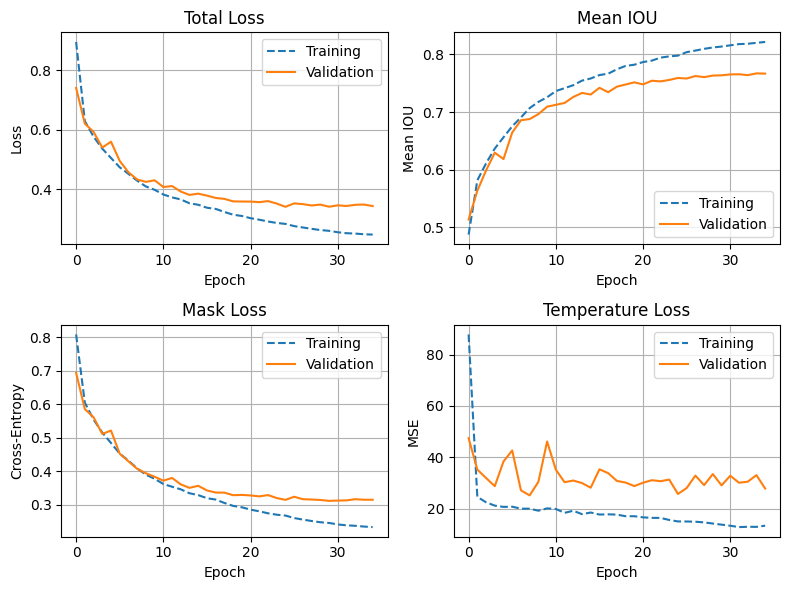

In [28]:
plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)
plt.plot(train_loss, label='Training', linestyle = 'dashed' )
plt.plot(val_loss, label='Validation', )
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.grid()

plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_mask_loss, label='Training',  linestyle = 'dashed')
plt.plot(val_mask_loss, label='Validation')
plt.title('Mask Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.grid()


plt.subplot(2, 2, 4)
plt.plot(train_temp_loss, label='Training',  linestyle = 'dashed')
plt.plot(val_temp_loss, label='Validation')
# plt.ylim(2, 30)
plt.title('Temperature Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid()


plt.subplot(2, 2, 2)
plt.plot(train_epoch_iou, label='Training', linestyle = 'dashed')
plt.plot(val_epoch_iou, label='Validation')
plt.title('Mean IOU')
plt.xlabel('Epoch')
plt.ylabel('Mean IOU')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

  ## save history
train_hist = np.array([train_loss,train_mask_loss, train_temp_loss, train_epoch_iou])
val_hist = np.array([val_loss, val_mask_loss, val_temp_loss, val_epoch_iou])

np.save('train_hist.npy', train_hist)
np.save('val_hist.npy', val_hist)


## Evaluate Training data 

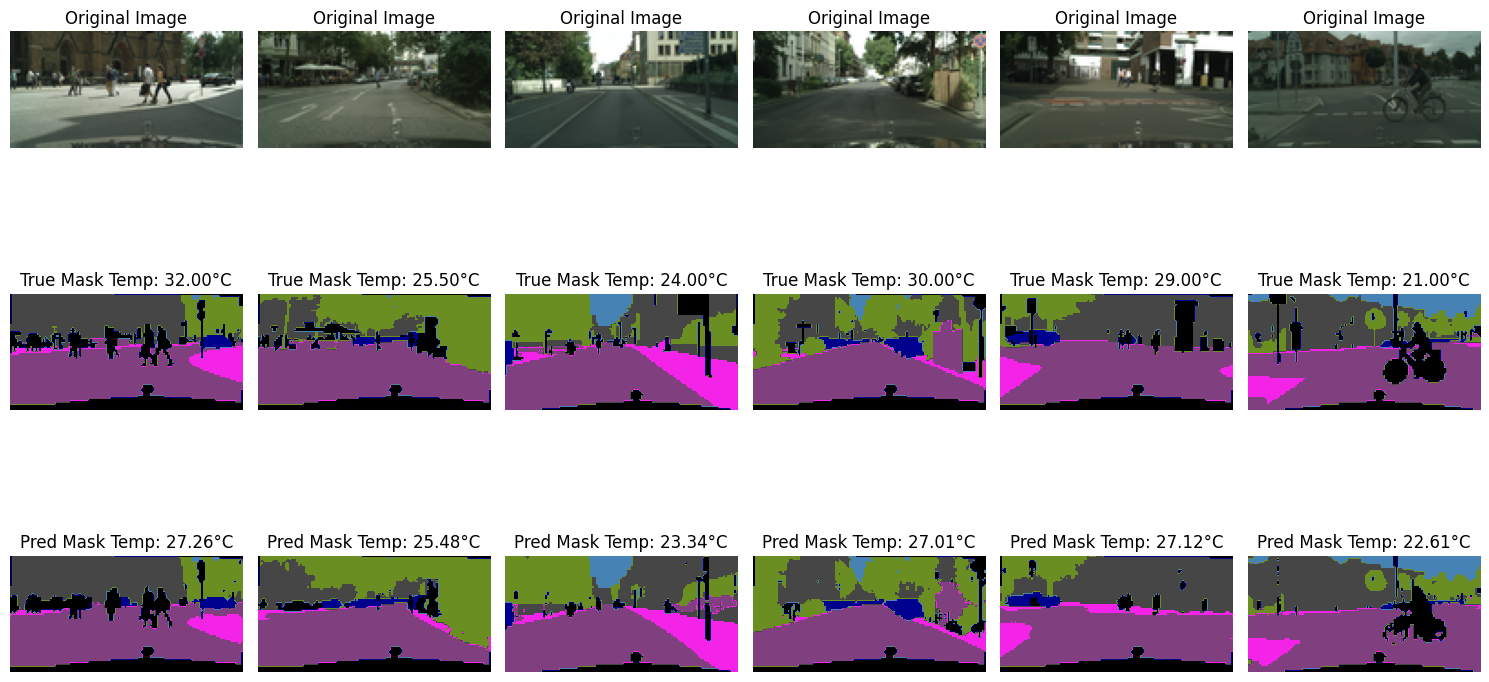

In [13]:
plot_predictions(model, train_loader, device, num_samples=6,  unnormalize= True, mean = mean , std = std, 
                #  temp_scale=(temp_min, temp_max)
                 )

## Evaluate Validation data

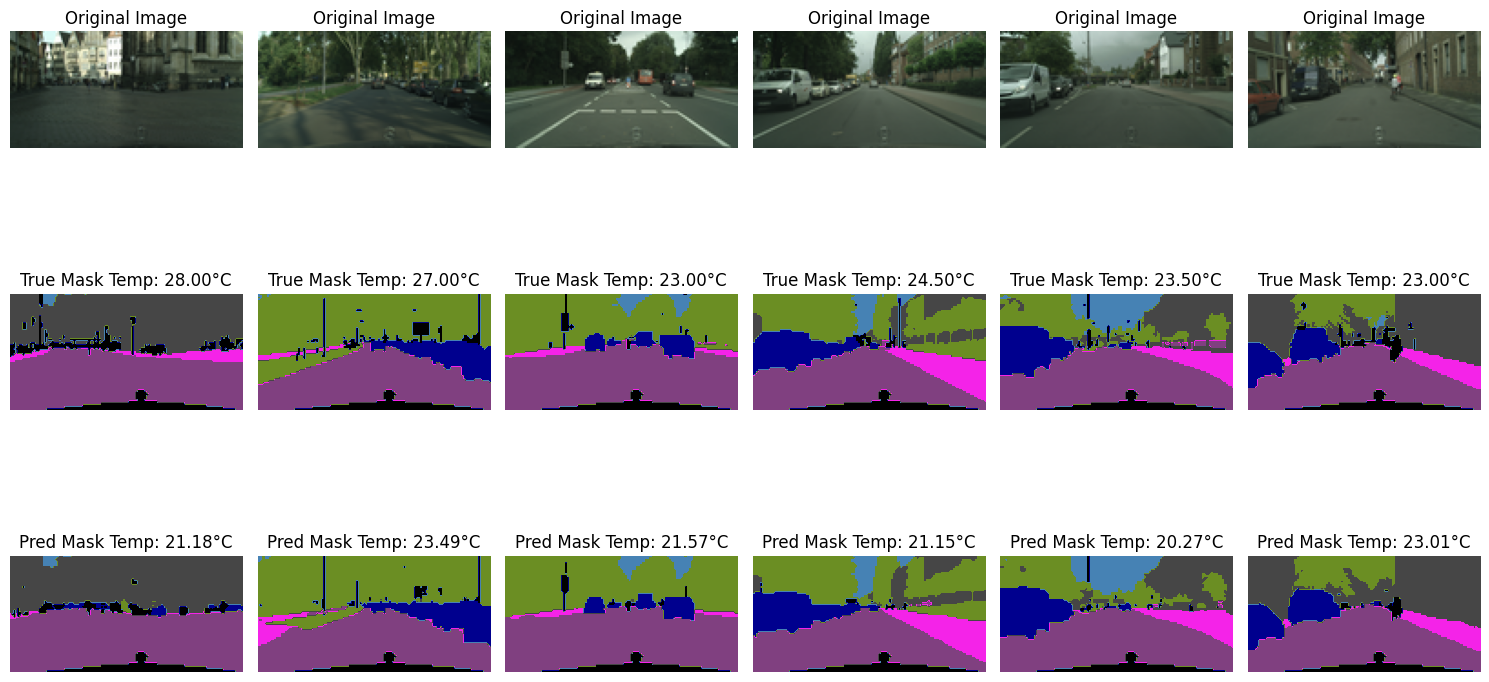

In [14]:
plot_predictions(model, val_loader, device, num_samples=6,  unnormalize= True, mean = mean , std = std, 
                #  temp_scale=(temp_min, temp_max)
                 )

In [15]:
# plot_metrics(model, val_loader, device, num_classes, 
#             #  temp_scale=(temp_min, temp_max)
#              )

In [25]:
from torch.utils.data import Subset
import random

test_dataset =   CityscapeSegTemp(root_dir = './data', split= 'test', 
                                #  device = device, 
                                 transform = aug,
                                #  temp_scale=(temp_min, temp_max)
                                 )



num_samples = 100
random_indices = random.sample(range(len(test_dataset)), num_samples)
test_dataset = Subset(test_dataset, random_indices)


test_loader = DataLoader(test_dataset, batch_size=6, shuffle=True)

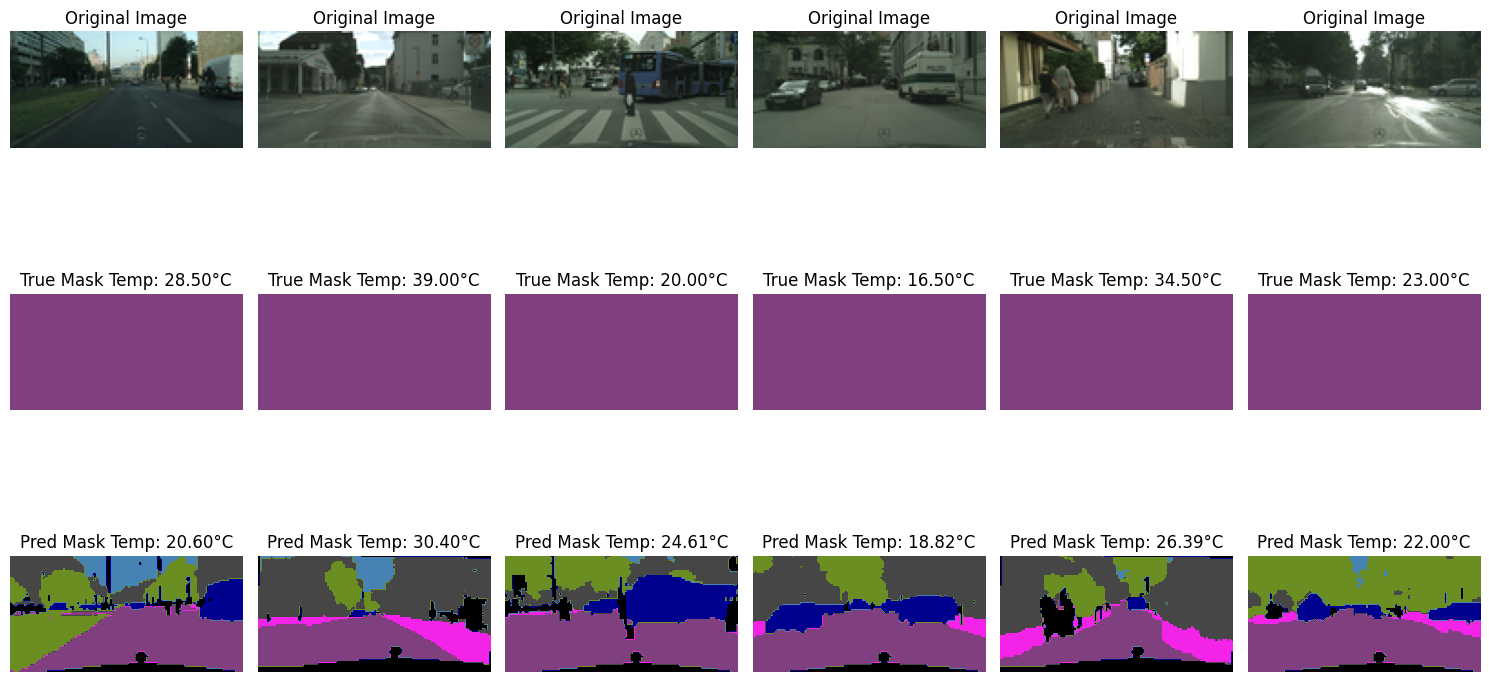

In [26]:
plot_predictions(model, test_loader, device, num_samples=6,  unnormalize= True, mean = mean , std = std, 
                #  temp_scale=(temp_min, temp_max)
                 )